<a href="https://colab.research.google.com/github/dockhs1313/19-lab/blob/master/SMILES_with_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **seq2seq RNN models with SMILES in keras** (정형수,노정민,이유선)

## Rdkit 설치

In [0]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2017.09.1 installation finished!


In [0]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [0]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

# 데이터 파일 추가와 확인

우리는 Rdkit 데이터와 원자 8개가 포함된 (C,N,H,F,O 등) GDB-11 데이터를 사용하여 일부 SMILES 스트링들을 훈련하고 시험할 것이다.   
이 데이터(GDB-11)는 원자와 결합 유형의 부분집합으로 생성될 수 있는 모든 분자를 포함한다.   
데이터 세트는 http://gdb.unibe.ch/downloads/에서 다운로드할 수 있다.

In [0]:
smifile = "gdb11_size08.smi"
data = pd.read_csv('/content/gdb11_size08.smi', delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(50029,)
(16677,)


embeding을 위해 one-hot encoded array 로 벡터화 한다.  
 context vector는 고정된 크기의 벡터 값을 전달하므로   
 벡터의 크기는 가장 큰 길이의 값을 기준으로 정한다.   
 우리는 가장 큰 길이 +5로 크기를 정하고 나머지 공란은 알파벳 'E' 로 채웠다.

In [0]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'[', 'H', '3', 'c', '#', 'n', 'F', ']', 'C', '4', 'o', 'E', 'N', ')', '=', '-', '1', 'O', '(', '!', '+', '2'}
22 28


N#CC#CC1COC1


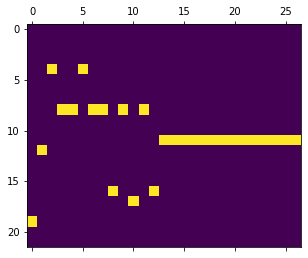

In [0]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.float)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [0]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!N#CC#CC1COC1EEEEEEEEEEEEEE'

## 텐서플로를 이용한 RNN 구조 만들기



In [0]:
try:

    %tensorflow_version 2.x  

except Exception:

    pass

TensorFlow 2.x selected.


In [0]:
#Import Keras objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

모델은 전체적으로 다소 단순하다. 64LSTM 셀에 단일 레이어는 입력 SMILES 문자열을 읽는데 사용된다. 레이어의 출력은 무시되지만 최종 내부 C 및 H상태는 연결되고 병목 레이어 'neck'으로 다시 결합된다. 이 구조는  attention mechanism의 fully connected network와 유사하다. 이것은 인코더로 구성된다.

In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

그런 다음 neck_output 디코더 LSTM 레이어에 설정되어야하는 상태를 디코딩하기 위해 두 개의 서로 다른 Dense 레이어를 통과한다.     
인코더에서 디코더로의 내부 상태의 이러한 재결합은 LSTM 계층 자체에 의해 인코딩 된 것과 다른 크기의 latent space를 사용할 수 있게 한다.
LSTM 레이어는 입력을 다시 한 번 수신하고 시퀀스의 다음 문자를 예측하는 작업을 수행한다. 따라서 분자와 문자 "!"의 잠복 표현에서 첫 번째 원자를 나타내는 다음 문자가 무엇인지 출력해야한다. (예 : "C", "N"등).   
따라서 Y 벡터가 X에서 상쇄된다. "!"문자가있는 벡터 이 훈련 방법은 한 번의 단계의 결과가 다음 단계의 입력으로 사용되는 접근법과 달리 교사 시행(Teacher forcing)이라고한다. 네트워크가 시퀀스 시작에서 실수를 할 수는 있지만 시퀀스의 후반부에 대한 교육에는 영향을 미치지 않는다.   
 이를 통해 디코더는 내부 상태를 공급 한 다음 전체 시퀀스를 구성 할 수 있는지 확인하는 것보다 훨씬 효율적으로 디코더를 학습시킨다. 각 단계에서 출력되는 LSTM 세포는 올바른 특성을 예측하기 위해 각 뉴런 작업과 함께 밀도가 높은 네트워크에 배치된다.

   
훈련을위한 최종 모델은 입력 레이어 객체와 출력 레이어에서 만들어진다.

In [0]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 22)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  22272       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

# 인코더

In [0]:
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam #Default 0.001
model.compile( optimizer='Adam', loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Train on 50029 samples, validate on 16677 samples
Epoch 1/200
50029/50029 [==============================] - 9s 182us/sample - loss: 1.1762 - val_loss: 0.8778
Epoch 2/200
50029/50029 [==============================] - 2s 45us/sample - loss: 0.7813 - val_loss: 0.6962
Epoch 3/200
50029/50029 [==============================] - 2s 45us/sample - loss: 0.6408 - val_loss: 0.6004
Epoch 4/200
50029/50029 [==============================] - 2s 46us/sample - loss: 0.5820 - val_loss: 0.5545
Epoch 5/200
50029/50029 [==============================] - 2s 46us/sample - loss: 0.5354 - val_loss: 0.5074
Epoch 6/200
50029/50029 [==============================] - 2s 46us/sample - loss: 0.4989 - val_loss: 0.4858
Epoch 7/200
50029/50029 [==============================] - 2s 47us/sample - loss: 0.4759 - val_loss: 0.4664
Epoch 8/200
50029/50029 [==============================] - 2s 45us/sample - loss: 0.4609 - val_loss: 0.4525
Epoch 9/200
50029/50029 [==============================] - 2s 46us/sample - loss: 0.4

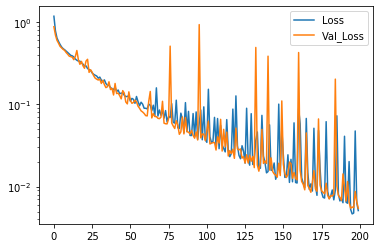

In [0]:
 plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

#디코더

이제 훈련된 자동 인코더의 일부를 사용하여 다양한 인코더 및 디코더 모델을 작성한다. in-put 레이어에서 다른 모델 내부의 out-put 레이어로 새 모델을 작성하는 것은 매우 간단하다. 모델이 만들어질 때 정의된 in-put 레이어는 재사용되고 neck_output은 출력으로 재사용된다. 이 모델은 벡터화 된 미소를 취하여 latent space로 인코딩한다.

In [0]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
      print (true, pred)

CC(C1CO1)N(C)CEEEEEEEEEEEE CC1C1CO1)N(C)CEEEEEEEEEEEE
CC1=NCCCNN1EEEEEEEEEEEEEEE CC1=CCCCNN1EEEEEEEEEEEEEEE
CC(C(C)=C)C(C)=OEEEEEEEEEE CC(C)C)=C)C(C)=OEEEEEEEEEE
NN(C(N)=N)C(N)=NEEEEEEEEEE NN(C(N)=C)C(F)=OEEEEEEEEEE
[O-][N+](=O)c1nnon1EEEEEEE [O-][N+](=O)c1nnnn1EEEEEEE
OC=C1C=NC(O)=N1EEEEEEEEEEE OC=C1C=NC(=)=N1EEEEEEEEEEE


다음에 필요한 모델은 latent space을 디코더 LSTM 셀에서 설정해야하는 상태로 디코딩할 수 있는 모델이다. latent space과 일치하는 새로운 입력이 정의되었지만 이전의 레이어를 재사용하여 h 및 c 상태를 얻을 수 있다. 그렇게 하면 가중치가 훈련된 모델에서 상속된다  
 *(attention mechanism)*

디코더 모델에는 약간 더 많은 작업이 필요하다. 배치 모드에서 학습되었지만 한 번에 한 문자를 예측하기 때문에 저장할 수 있는 공간이 필요하다. 따라서 새로운 batch_shape 와 상태유지 LSTM 레이어를 제외하고 이전과 똑같다.

디코더 모델을 정의한 후 학습된 자동 인코더 모델에서 해당 가중치가 전송된다.

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [0]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [0]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


In [0]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")
1
sample_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(1, 1, 22)]              0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 64)                22272     
_________________________________________________________________
dense_4 (Dense)              (1, 1, 22)                1430      
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


# Using the latenet space as a fingerprint

latent 모델에 대한 SMILES은 latent space와 같은 SMILES를 fingerprint로 인코딩하는 데 사용할 수 있다.

fingerprint의 유용한 기능은 유사한 분자가 유사한 fingerprint를 생성하는 것이다. 유사한 분자가 latent space 에서 유사한 벡터를 생성하는지 확인하기 위해 유사한 분자에 대한 간단한 검색을 수행할 수 있다. 여기서 latent 벡터 간의 절대 차이는 유사성의 메트릭으로 사용 된다. 이 테스트는 유사한 분자가 유사하지 않은 latent 벡터를 얻을 수 있다는 것을 배제하지는 않지만 빠른 테스트다.

In [0]:
x_latent = smiles_to_latent_model.predict(X_test)

첫 번째는 쿼리 분자다. 그것들은 비슷해 보이지만 분자 유사성에 대한 우리의 이해를 따르기보다는 SMILES string이 매우 유사하기 때문일 수 있다. latent space에서 가장 다른 분자가 무엇인지 살펴보자.

[    5 14589 15472  3991 15039  1243  5251   744  1075  2144]
45051    COCc1cocn1
44719    COCc1ccno1
45061    COCc1conn1
44727    COCc1cnno1
45069    COCc1ncon1
45007    COCc1ccoc1
44751    COCc1ncno1
45025    CCOc1cnoc1
Name: smiles, dtype: object


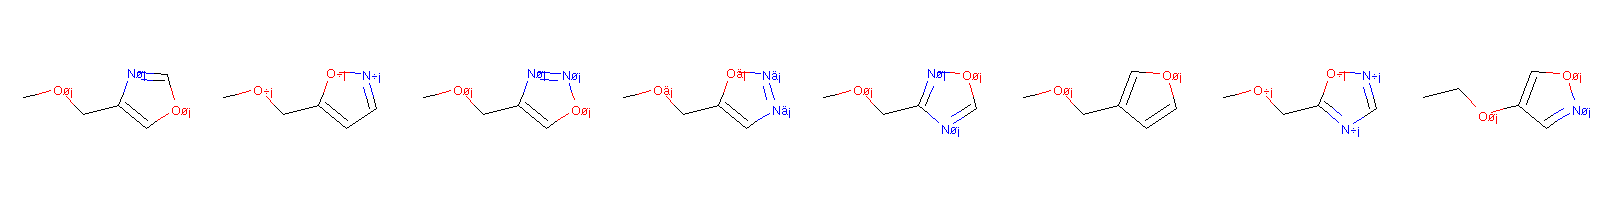

In [0]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print (sorti[0:10])
print (smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

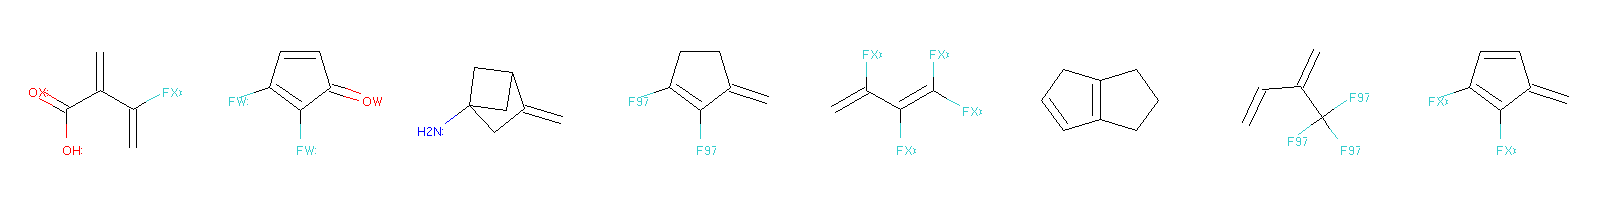

In [0]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

계산된 LogP 및 MR이 latent space의 PCA 감소가 어떻게 mapping 되는지 확인 해보자.

[0.28907117 0.19593118] 0.48500234


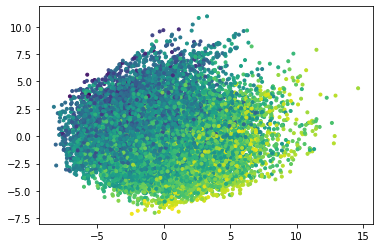

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

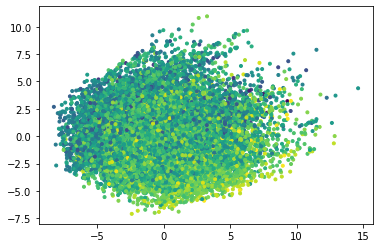

In [0]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

# latent space에서 모델링 속성
fingerprint가 QSAR 모델의 기초로 잘 작동하는지 확인해 보았다.
QSAR 모델링의 목표 값에 대한 프록시로서 예측된 LogP 모델이 작성된다. 모델링된 속성을 사용하여 모델을 작성하는 것은 데모 목적으로만 수행된다.

In [0]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

from tensorflow.keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

x_train_latent= np.asarray(x_train_latent)
logp_train= np.asarray(logp_train)

logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, callbacks = [rlr])

Train on 50029 samples
Epoch 1/400
50029/50029 [==============================] - 1s 25us/sample - loss: 0.2912
Epoch 2/400
50029/50029 [==============================] - 1s 19us/sample - loss: 0.2000
Epoch 3/400
50029/50029 [==============================] - 1s 20us/sample - loss: 0.1859
Epoch 4/400
50029/50029 [==============================] - 1s 20us/sample - loss: 0.1739
Epoch 5/400
50029/50029 [==============================] - 1s 19us/sample - loss: 0.1640
Epoch 6/400
50029/50029 [==============================] - 1s 19us/sample - loss: 0.1597
Epoch 7/400
50029/50029 [==============================] - 1s 18us/sample - loss: 0.1551
Epoch 8/400
50029/50029 [==============================] - 1s 18us/sample - loss: 0.1508
Epoch 9/400
50029/50029 [==============================] - 1s 18us/sample - loss: 0.1453
Epoch 10/400
50029/50029 [==============================] - 1s 18us/sample - loss: 0.1414
Epoch 11/400
50029/50029 [==============================] - 1s 18us/sample - loss: 0.1

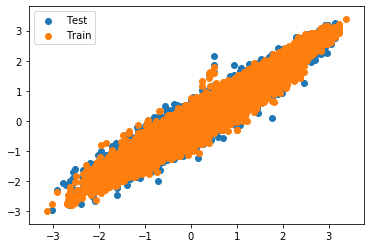

In [0]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

모델링된 속성을 모델링할 때 훨씬 더 잘 맞을 것으로 예상된다.

# From latent space to SMILES
latent 공간을 샘플링하려면 두 단계가 필요하다. 먼저 latent_to_states_model을 사용하여 c 및 h 상태를 계산한 다음 디코더 LSTM 네트워크의 초기 상태를 설정한다. LSTM 네트워크에는 입력 문자 벡터가 입력되고 끝 문자 "E"가 나타날 때까지 다음 문자를 반복적으로 샘플링한다.

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
smiles = latent_to_smiles(x_latent[0:1])
print (smiles)
print (smiles_test.iloc[0])

NCCC1OC=NO1
NCCC1OC=NO1


In [0]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print (smiles)
        wrong = wrong + 1
print ("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

RDKit ERROR: [11:25:09] SMILES Parse Error: unclosed ring for input: 'CC1C(CNN2)C=C1O'


CC1C(CNN2)C=C1O


RDKit ERROR: [11:25:10] Explicit valence for atom # 1 C, 6, is greater than permitted


CC(C)(CC=C)(=O)C


RDKit ERROR: [11:25:11] SMILES Parse Error: unclosed ring for input: 'c1[nH]cc2oc2nn12'


c1[nH]cc2oc2nn12


RDKit ERROR: [11:25:12] SMILES Parse Error: unclosed ring for input: 'C1C2OC1C(=O)C2C3'


C1C2OC1C(=O)C2C3


RDKit ERROR: [11:25:13] SMILES Parse Error: extra open parentheses for input: 'CC(=CC1ON1CC=N'


CC(=CC1ON1CC=N


RDKit ERROR: [11:25:15] SMILES Parse Error: extra close parentheses for input: 'NNC(CN)=CF)C'


NNC(CN)=CF)C


RDKit ERROR: [11:25:17] SMILES Parse Error: syntax error for input: 'CC(=C)C1CC(1)CN'


CC(=C)C1CC(1)CN
FC1CN2C2NC=N1


RDKit ERROR: [11:25:19] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 350 in file /opt/conda/conda-bld/rdkit_1507355913765/work/Code/GraphMol/ROMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(bond_pin->getBeginAtomIdx(), bond_pin->getEndAtomIdx(), d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [11:25:23] Can't kekulize mol.  Unkekulized atoms: 1 2 7
RDKit ERROR: 


Cc1non(C)=Cn1


RDKit ERROR: [11:25:30] SMILES Parse Error: extra open parentheses for input: 'O=C1C(CN2CO=C1F'


O=C1C(CN2CO=C1F


RDKit ERROR: [11:25:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3
RDKit ERROR: 


Nc1cnc(=N)n1C
1.1 percent wrongly formatted smiles


RDKit ERROR: [11:26:29] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:26:29] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:26:29] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:26:29] Explicit valence for atom # 4 O, 3, is greater than permitted


NCCC1=ONCC1
NCCC1=OCON1
CNC1CO=CCO1
CNC1C=OCCO1


RDKit ERROR: [11:26:29] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [11:26:29] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [11:26:30] SMILES Parse Error: unclosed ring for input: 'CC1=NOCCCC=N'
RDKit ERROR: [11:26:30] SMILES Parse Error: unclosed ring for input: 'CC1=NOCCCC=N'


CN=CC1CCO1N
CN=CC1CCO1N
CC1=NOCCCC=N
CC1=NOCCCC=N


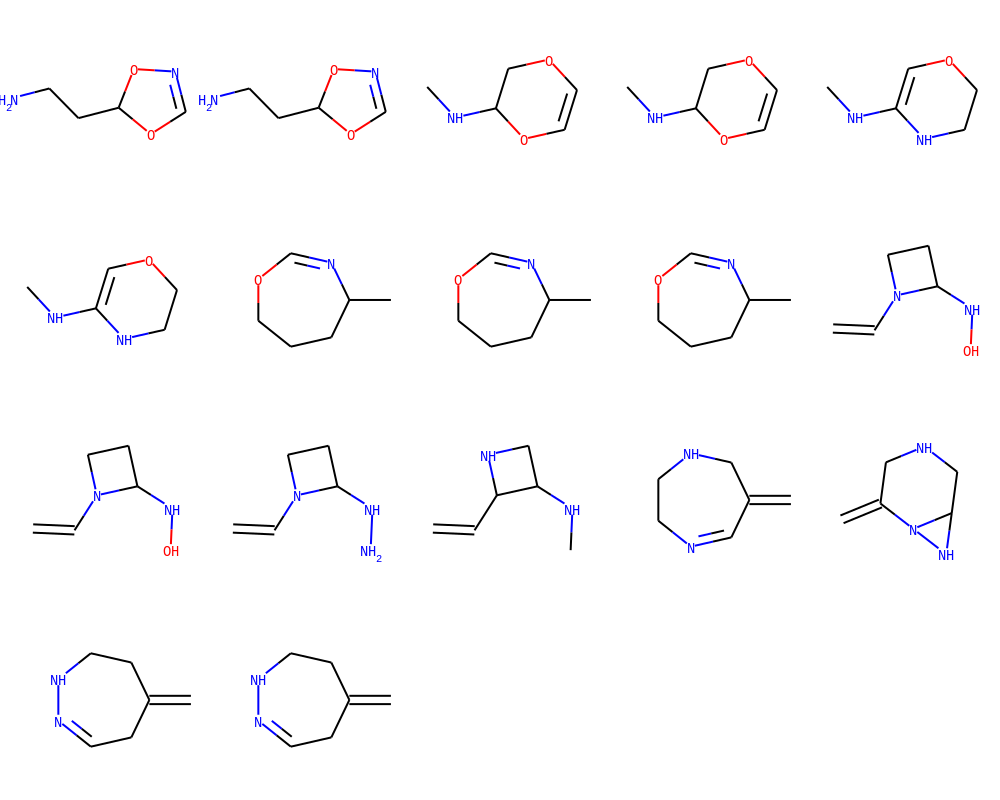

In [0]:
#Interpolation test in latent_space
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print (smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

25 개 분자 중 4 개를 파싱 할 수 없기 때문에 잘못된 샘플링이 더 높은 것 같다. interpolation(보간)은 또한 latent space의 약간 다른 영역에 대해 동일한 분자가 어떻게 생성되는지를 보여준다. 이것은 분자가 불연속적이고 latent space이 연속적이라는 것을 반영하며, 두 분자 사이의 경계에 있을 때 실패 할 가능성이 높다.
검사해야 할 또 다른 흥미로운 특성은 기존 분자 벡터에 약간의 무작위성을 추가함으로써 리드 분자와 다소 유사한 신규 분자가 있을 수 있는지이다.

RDKit ERROR: [11:27:28] Explicit valence for atom # 6 O, 4, is greater than permitted
RDKit ERROR: [11:27:28] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:27:28] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [11:27:28] SMILES Parse Error: unclosed ring for input: 'NCCOC=C1CO'
RDKit ERROR: [11:27:28] Explicit valence for atom # 4 O, 3, is greater than permitted


NCCC1OCO1=O
NCCC=ON1CC1
NCCC1ON=C=O1
NCCOC=C1CO
NCCCO1C=OO1


RDKit ERROR: [11:27:28] SMILES Parse Error: unclosed ring for input: 'NCCC#COC1O'
RDKit ERROR: [11:27:28] SMILES Parse Error: unclosed ring for input: 'NCCCC1=OOC'
RDKit ERROR: [11:27:28] SMILES Parse Error: extra open parentheses for input: 'CNOC1(CCO1F'
RDKit ERROR: [11:27:28] SMILES Parse Error: unclosed ring for input: 'NCCC1OC=NF'
RDKit ERROR: [11:27:28] Explicit valence for atom # 6 O, 4, is greater than permitted
RDKit ERROR: [11:27:28] SMILES Parse Error: unclosed ring for input: 'NCCCC1OCF'


NCCC#COC1O
NCCCC1=OOC
CNOC1(CCO1F
NCCC1OC=NF
NCCC1COO1=O
NCCCC1OCF
NCCCO1=OCn1
NCCC=C1OO1C
NCCCO=C1NN1
NCCCN1=CNN1


RDKit ERROR: [11:27:28] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [11:27:28] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [11:27:28] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:27:28] Explicit valence for atom # 4 N, 4, is greater than permitted


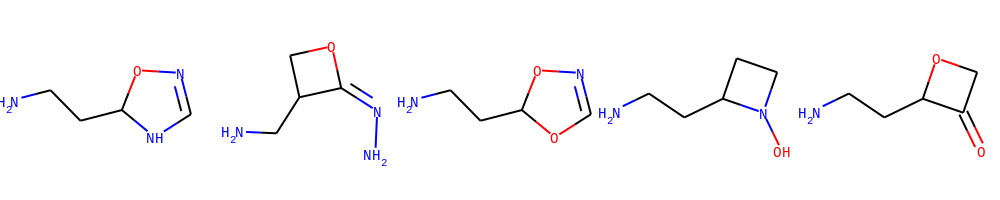

In [0]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print (smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)

여기서 우리는 실제로 많은 잘못된 SMILES가 생성되는 것을 보지만 그럼에도 불구하고 latent vector를 인코딩하는 데 사용된 것과 다소 유사할 수 있는 일부 분자를 볼 수 있다. (위 보간에서 첫 번째 분자와 비교). 스케일링을 조정하면 창의성을 튜닝할 수 있다.

# **hetero encoding**

#1.도입

auto encoder는 분자를 latent space의 디코딩 및 샘플 영역뿐만 아니라 latent vector 표현으로 전환하기 위한 심층 학습 솔루션으로 등장하였다.   
오토인코더는 입력 정보를 압축하여 코드 계층으로 변경하는 인코더와 압축 벡터 표현(잠재 공간 벡터)에서 원래의 입력을 재현하는 디코더 부분으로 구성된다.   
훈련 후에, 인코더는 자동인코더에서 추출될 수 있고 분자의 벡터 표현을 계산하는 데 사용된다.    
이것들은 분자의 화학적 공간을 위한 일종의 finger print나 GPS로 사용될 수 있다. 디코더는 훈련 중에 사용된 분자 표현에서 SMILES와 같은 분자 표현으로 되돌아가는 데 사용될 수 있다.   
이것은 디코더의 확률 출력을 샘플링할 수 있기 때문에, 디코더를 분자 드 노보 생성을 위한 조종 방법으로 사용할 수 있게 하여, 새로운 분자를 만들 수 있지만 잠재된 공간의 포인트에 가까운 분자를 만든다. 또는 벡터에 적절한 양의 무작위 노이즈를 추가하여 근처의 latent space의 분자를 탐색할 수 있다.

다양한 인코더-디코더 아키텍처가 제안되었고 인코더 출력 기능은 가변 오토인코더 (variational autoencoders)와 적성 오토인코더(adversarial autoencoders) 를 사용하여 정규화 또는 조작되었다.    
두 개의 합성곱 신경망(CNNs)과 T순환신경망(RNNs)은 모두 인코더 부분에 사용되어 왔으며, 디코더 부분은 대부분 게이트 반복 단위(GRU) 또는 장기 기억 세포(LSTM) 를 가진 RNN을 기반으로 하여 더 긴 시퀀스 메모리를 사용하였다.  

---------

**여기서 SMILES String에 기초한 오토엔코더는 동일한 근본적인 문제에 직면해 있다.   
latent space는 분자를 나타내는 것인가 아니면 분자를 나타내는 SMILES string의 응축된 표현일까?**

<그림1>

![대체 텍스트](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6316879/bin/biomolecules-08-00131-g001.jpg)

SMILES 언어 규칙으로 인해 여러 개의 다른 SMILES가 동일한 분자를 나타낼 수 있다.
  
이는 SMILES 열거 기법으로 데이터 확대로 이용되었다. 동일한 분자의 서로 다른 SMILES 표현을 가진 간단한 challenge는 사용되는 특정 SMILES 형태 때문에 동일한 분자가 latent space의 다른 부분에 있게 된다는 것을 보여준다.

  
 <그림 1>은 RNN 자동인코더에 RNN의 잠재 공간에 투영한 후 동일한 세 개의 분자를 보여준다. 분자의 서로 다른 SMILES 표시는 일부 군집화가 관찰될 수 있지만, 결국 latent space의 매우 다른 영역에 투영된다. 따라서 latent space는 특정 SMILES strings 에 대한 정보도 포함하고 있으며, 이전에 언급했던 분자뿐만 아니라 이 과제를 해결하는 한 가지 방법은 분자 생성을 위해 특수 엔지니어링된 네트워크와 그래프 기반 접근법을 사용하는 것이다.

 


**결과를 엔지니어링하기 위한 대안으로, SMILES enumeration 혹은 헤테로 인코더 (chemical heteroencoders)을 만들기 위한 화학적 이미지 임베딩( chemception image embedding)을 사용하는것이 가능하다고 제안 됐다.**

<그림2>

![대체 텍스트](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6316879/bin/biomolecules-08-00131-g002.jpg)

Chemical heteroencoders 는 오토엔코더(autoencoders)와 유사하지만 분자의 한 표현에서 다른 표현으로 번역된다.   
톨루엔 분자는 서로 다른 canonocial(정규화된) SMILES 또는 2D 임베딩으로, enumerated(열거화된) SMILES 문자열로 나타낼 수 있다.  
 오토엔코더는 canonical SMILES strings(정규화된 스마일 열들)을 잠재된 공간(latent space)으로 변환한다(파란색 화살표).   
반면에, heteroencoders(녹색 화살표)에는 더 많은 가능성이 존재한다.  

#2.결과

##2.1. GDB-8 Dataset Based Models

모든 모델은 full convergence를 위해 훈련되었고, 훈련과 테스트의 유사한 손실 함수 값을 얻었으며 이 값들은 아래  *Tabel 1* 에 나타나 있다.<br>
열거된 SMILES output에 대해 훈련된 모델들은 최종 손실이 현저하게 크지만, 테스트 세트로부터 계산된 latent space 벡터를 샘플링할 때는 모두 낮은 수준의 잘못된 SMILES를 보인다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/1.PNG?raw=true)

**GDB-8 데이터 세트의 서로 다른 입출력 표현에 대해 훈련된 모델의 속성**



##2.1.1. Molecular and Sequence Similarity

동일한 기준 분자를 사용하여 유사도를 계산한 후(테스트 세트의 latent space 벡터, Morgan fingerprint, 시퀀스 alignment scores를 기반으로) , 상관 계수($R^2$)를 계산했다.<br>

두 개의 다른 배열의 SMILES의 예가 <그림 3>에 나타나 있다. <br>

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%982.PNG?raw=true)

<br>
<그림 4> 는 테스트 세트에서 첫 번째 분자와 나머지 분자의 alignment scores와 latent space 유사성에 대한 산점도를 예시로 보여준다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%983.PNG?raw=true)

<br>
동일한 latent space의 유사성과 Morgan fingerprint 유사성 사이의 상관관계는 SMILES 문자열과 무관하며, 예시 산점도는 <그림 5> 와 같다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%984.PNG?raw=true)

시퀀스 alignment score와 fingerprint 기반 유사성 둘 다 latent space 유사성과 상관관계를 가지고 있는데, 이는 latent space가 적어도 분자간 유사성에 대한 우리의 일반적인 이해와 어떻게든 관련이 있음을 보여준다.<br><br>
GDB-8 데이터 세트에서 훈련된 모든 모델의 특성과 상관관계는 위의 <Table 1> 에 수록되어 있다.<br>

표준 SMILES에 대해 훈련된 디코더가 있는 모델은 fingerprint 유사성과 latent space사이의 상관관계보다 latent space와 SMILES 시퀀스 유사성 메트릭 간의 상관관계가 현저하게 더 크다. 이와는 대조적으로 디코더를 열거된 SMILES를 사용하여 훈련할 때, fingerprint와 시퀀스 유사성은 latent space 유사성과 더 비슷한 수준에 있다. 분자의 이미지 embedding에 기초한 hetero encoder는 가장 낮은 연관성을 가지며, 현저하게 다른 latent space를 나타낸다.

아래의 그림 두 개는 쿼리 분자를 사용하여 테스트 세트의 latent space에서 유사성을 찾아낸 결과를 나타낸다.<br>
can2enum 모델<그림 7>의 분자들은 can2can 모델<그림 6> latent space의 분자들보다 더 유사해 보인다. 두 세트 사이에 겹치는 부분이 있기 때문에, 어떤 부분에서는 두 latent space가 연관되어 있다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%985.PNG?raw=true)

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%986.PNG?raw=true)

##2.1.2. Error Analysis

일반적으로 모델은 큰 비율의 유효 SMILES를 만든다<Table 1>.
그러나 입력과 출력에 열거값을 사용하면 디코딩된 분자가 인코딩된 분자와 같지 않은 출력의 비율이 크게 증가한다.<br>
<그림 8>은 can2enum 모델에 대한 오류 유형과 중첩을 보여준다.
<br>
테스트에 사용된 1000개 중 494개의 분자는 유효한 SMILES였지만 입력 분자와는 동일하지 않았다. 또한 220개의 scaffold, 42개의 화학식 총합, 14개의 결합형태나 결합 수가 잘못되었다. 대다수(251개)는 맞는 scaffold, 맞는 원자와 정확한 결합을 가지고 있지만, 겉보기에는 분자를 잘못된 순서로 합한 것처럼 보였다. 결합 형태와 원자는 원칙적으로 SMILES의 독립적 작업이며, 모델들은 SMILES 배열의 영향을 받는 scaffold 재현과 원자 순서에 더 많은 어려움을 겪는다. 다른 hetero encoder 모델들의 결과도 유사하다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%987.PNG?raw=true)

##2.1.3. Enumeration Challenge

인코더가 같은 분자의 서로 다른 SMILES를 처리하는 기능은 PCA 감소에 대해서 latent space를 나타내어 테스트했다(c.f. 그림 1).<br>

<그림 9>는 인코더와 디코더 중 하나에 대해 SMILES를 사용하여 hetero encoder를 훈련시킴으로써 향상되는 것을 보여준다. 
SMILES strings를 사용하여 인코더를 훈련시키면 가장 엄격한 클러스터링(enum2can)이 주어지며, 인코더가 SMILES string의 실제 직렬화(객체를 데이터 스트림으로)과정에서 독립적으로 동일한 분자를 인식하는 법을 배웠음을 알 수 있다. 훈련 과정 중 인코더에 여러개의 다른 SMILES string을 보여줌으로써, 인코더는 인코더에 표시된 SMILES 형태에 관계 없이 디코더의 SMILES 형태를 재현하는 데 가장 적합한 latent space 좌표를 생성할 수 있다. enum2enum 모델도 유사하다.<br>
또한 can2enum 모델은 <그림 1>의 can2can 모델보다 더 빽빽한 클러스터링을 보여주는데, 이는 인코더 자체는 서로 다른 SMILES 형태로 훈련되지 않았지만 heteroencoding 자체가 latent space를 변경한다는 것을 보여준다. 그 대신에 이 모델은 더 복잡한 작업을 수행하고 있다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%988.PNG?raw=true)

##2.1.4. Sampling Using Probability Distribution

<그림 10>은 can2can과 can2enum 모델의 샘플링 차이를 보여준다. 디코더는 각 단계에서 확률 분포를 출력하며, 확률에 따라 무작위로 샘플링할 수 있다(다항 샘플링).<br>
can2can 모델의 경우, 이 샘플링 전략과 가장 확률이 높은 다음 문자 선택 사이에는 거의 차이가 없다. <br>
can2enum 모델은 샘플링 시작 시 다음 문자에 훨씬 더 큰 불확실성을 보여준다. 첫 번째 문자는 "C"일 가능성이 가장 높지만 "N"과 "F"도 가능하다. 모델이 "C"를 샘플링할 때, 다음 문자는 분기(branching)의 "C", "(", 또는 고리 시작의 "1"이다. 그 다음에 "C"를 샘플링하기 때문에, 다음에 고리의 시작을 선택해야 한다. 샘플링이 끝날때쯤, 디코더는 앞에 샘플링된 것들로 분자를 완성할 수 있는 유일한 방법이 있기 때문에 마지막 여섯 문자로 완전히 정확해진다.<br>

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%989.PNG?raw=true)

*Table 2* 는 단일 분자의 latent 좌표를 이용해 샘플링된 분자에 대한 몇 가지 통계를 보여준다. <br>
인코더와 디코더 모두에서 정규화된 SMILES에 대해 훈련된 모델은 하나의 SMILES 형태와 하나의 분자가 샘플링되기 때문에, 재생성하고자 하는 SMILES에 매우 정확하다.<br>
이와는 대조적으로 열거된 SMILES로 훈련된 디코더는 같은 분자의 다른 SMILES 형태를 생성하지만 다른 분자도 생성한다.<br>

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%9811.PNG?raw=true)

2개의 LSTM 레이어가 있는 보다 복잡한 모델은 단일 레이어 버전보다 작업을 조금 더 잘 처리한다. 2층 모델에서 샘플링된 분자의 예는 <그림 11>에 나타나 있다.



![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%9810.PNG?raw=true)

##2.2. QSAR Modelling Using ChEMBL Trained Heteroencoders

QSAR 모델을 만들기 위한 전체 단계는 <그림 12>에 나타나 있다. ChEMBL 데이터 세트에 사용된 인코더-디코더 모델의 훈련으로, 훈련 세트의 can2can, enum2enum 및 enum2enum 대해 각각 약 0.001, 0.01, 0.10, 0.11의 최종 손실이 발생했다.<br>

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%9812.PNG?raw=true)

다양한 인코더/디코더 구성의 재구성 성능은 *Table 3* 에 제시되어 있다.<br>
ECFP4 fingerprint와 세 개의 서로 다른 신경망 모델의 코드 층에서 얻은 다른 벡터들에 기초하여 수행된 QSAR 모델링의 성능은 *Table 4* 와 같다.<br><br>

ECFP 기반 베이스라인 모델에서 can2can 벡터 기반 모델로의 약간의 개선이 있으며, hetero encoder로 인코딩된 latent 벡터에 기초한 모델에 대한 추가 개선도 있다. 
세 개의 서로 다른 hetero encoder들은 QSAR 모델링에서 서로 매우 유사한 latent 벡터를 생성하는 것처럼 보이며, 평균 성능은 can2can에서 enum2enum으로 상승하는 경향이 있다.

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%9813.PNG?raw=true)

![대체 텍스트](https://github.com/JungMinNoh/capture/blob/master/%EC%BA%A1%EC%B2%9814.PNG?raw=true)

흥미로운 점은 각 구성에 대한 코드층의 뉴런의 약 40%가 활성화되지 않는다는 것이다. 이는 ReLU 활성화함수의 사용과 관련이 있을 수 있으며, 코드 층을 줄이거나 늘리면 거의 같은 비율의 비활성 뉴런이 발생한다. 그러므로 latent 벡터는 선택된 수의 뉴런보다 더 빽빽하다.

# Transformer

기존 인코더 디코더 모델을 발전시킨 모델
가장큰 차이점은 RNN을 사용하지 않는다
트랜스 포머는 기존 RNN
기반 인코더 디코더보다 학습속도와 정화도 부분에서 뛰어나 관심을 많이 끌었다.

트랜스 포머가 빠른이유가 무엇인가. 바로 트랜스포머는 RNN을 사용하지 않는데에 있다. = 병렬화
RNN이 처음 입력된 단어를 시작하여 하나하나 계산하여서 하는방면 트랜스포머는 한번에 처리한다.

아래는 전통적인 RNN 기반 인코더 디코더

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/1.PNG?raw=true)

트랜스포머는 한번의 연산으로 각 단어의 중요 정보들을 인코딩을 하게 됩니다.
디코더부분에서는 'start' 부터 'end'까지 순차적으로 디코딩을 하고있다. 이를 보면
기존에 전통적인 인코더 디코더의 컨셉을 간직하고 있다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/2.PNG?raw=true)

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/3.PNG?raw=true)

자연어 처리에서 문장을 처리할때 실제 단어의 위치 및 순서는 상당히 중요하다

RNN이 단어의 위치와 순서정보를 잘 활용하는건데 없다면 어떻게 될까?

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/4.PNG?raw=true)

정답은 포지션널 인코딩이다. 이는 인코더와 디코더의 값마다 상대적인 위치 정보를 더해주는 기술이다.
포지셔널 인코딩은 사인 코사인을 이용한다. 장점은 
1. 항상 -1~1사이의 값이 나온다. 
2. 학습중인 길이의 정보보다 더 긴 정보가 들어와도 에러없이 상대적인 인코딩 값을 준다.

##Positional Encoding

![대체 텍스트](https://miro.medium.com/max/262/1*yWGV9ck-0ltfV2wscUeo7Q.png)
![대체 텍스트](https://miro.medium.com/max/282/1*SgNlyFaHH8ljBbpCupDhSQ.png)

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/5.PNG?raw=true)

## Self attention

Query, Key, Value는 행렬의 곱으로 한번에 구할수 있으며 벡터의 형태이다.

어떤 단어와의 상관관계를 구할때 Query에 Key 값을 곱해준다.

Query와 Key를 곱한 값은 어텐션 스코어라고 한다.

이숫자가 높을수록 연관성이 높다. 이를 소프트맥스를 적용한다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/6.PNG?raw=true)

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/7.PNG?raw=true)

이 스코어와 Value값을 곱해준다. 값이 낮을 수록 희미해짐을 볼 수 있는데 이는 연관성이 떨어짐을 의미한다.
이를 다 더하면 하나의 값이 나오는데 이 값은 단어 'I'가 아닌 이 문장 속에서 단어 'I'가 지닌 전체적인 의미를 지닌 벡터이다.
단어 임베딩은 벡터이므로 행렬로 표시할 수가 있다. 단어 Query, Key, Value 가 모두 행렬이므로 어텐션 연산은 한번 연산으로 계산할 수 있다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/8.PNG?raw=true)

트랜스 포머는 attention layer를 한번에 6개를 수행하는 Multi-head attention이다. 그림에서는 간단히 3개를 표시했다.
이 multu head attention을 수행하면서 얻는 이점은 무엇일까? 유명한 예제를 참고해보자

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/9.PNG?raw=true)

이러한 문장이 있다 The animal didn't cross the street because it was too tired. 여기서 it은 무엇을 의미할까
이 애매한 문장에서 2개의 다른 attention이 it 하고 연관이 있는 단어에 포커싱을 하고있다.
첫번째 attention은 animal에 포커싱을 맞추었고 다른하나는 tired 에 포커싱을 맞추었다.
이런 모호한 문장을 여러 attention을 사용하여 문제점을 보완해 나가는게 multi head attention의 장점이다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/10.PNG?raw=true)

인코더의 전반적인 구조를 살펴보면 multi head attention을 통해 나온 벡터들을 이어붙여 새로운 벡터와 곱해져
기존 워드 임베딩과 같은 차원을 갖는 벡터로 출력이 된다. 각각의 벡터는 Fullyconnected vector를 통해 입력과 동일한 벡터로 출력된다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/11.PNG?raw=true)

워드 임베딩에 포지셔널 어텐션을 더해주는데 역전파에 의해 이 포지셔널 인코딩이 많이 손실될 수가 있다.
이를 보완하기 위해 residual connection으로 입력된 값을 다시한번 더해준다.

이게바로 인코더 블럭인데 입력 값과 출력 값이 같다보니 인코더 레여를 여러개 붙여서 사용할 수있다.
실제 트랜스포머 인코더는 6개를 이어붙인 구조인데 각각의 인코더는 서로의 가중치를 공유하지 않고 따로 학습 시킨다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/12.PNG?raw=true)

인코더와 상당히 유사하게 생겼다. 첫 단어부터 끝 단어까지 순차적으로 번역한다. 
디코더는 인코더에서와 같이 병렬 어텐션 구조를 적극 활용한다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/13.PNG?raw=true)

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/14.PNG?raw=true)

인코더에는 multi head attention, feed forward layer, residual connection 디코더는 인코더와 상당히 유사한 구조를 지니고있지만
몇가지 차이점이 있다.
1. Masked Multi head attention - masked(지금까지 출력된 값에만 attention을 적용하기 위하여 붙여짐)
2. Multi head attention - 인코더와 같이 key, value, query값을 사용하나 디코더의 입력값을 query로 사용하고 인코더의 최종 출력값을 key와 query로 사용한다.
3. feed forward를 통해서 값을 출력한다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/15.PNG?raw=true)

Linear layer은 softmax 입력값으로 들어갈 logit을 생성한다. Softmax는 이를 확률로 바꾸어준다.
트랜스포머는 마지막에 Label Smoothing이라는 기술을 사용해 모델의 퍼포먼스를 한단계 업그레이드 시킨다.
보통 딥러닝 모델을 소프트맥스로 학습할 경우에는 레이블을 원핫인코딩으로 전환해주는데 0이 아니지만 0에 가깝고 1에 가깝지만 1이아닌 값으로 변환시켜준다.
모델이 학습시 모델이 너무 학습데이터에 치중하지 못하도록 방지하는 기술이다. 예를들어 Thank you가 있을 때 '고마워' 와 '감사합니다'로 번역이 될 수 있는데
원핫인코딩을 하게 되면 이 상이한 벡터들의 연관성을 찾지 못하고 결국 학습을 잘 하지 못하게 된다.

![대체 텍스트](https://github.com/dockhs1313/19-lab/blob/master/%EA%B3%B5%EC%A0%84%EC%9D%91%20%EA%B8%B0%EB%A7%90%20%ED%8C%80%ED%94%8C/%EC%82%AC%EC%A7%84/16.PNG?raw=true)

#참고 문헌

Improving Chemical Autoencoder Latent Space and Molecular De Novo Generation Diversity with Heteroencoders - Esben Jannik Bjerrum1,* and Boris Sattarov2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6316879/#B1-biomolecules-08-00131


https://www.wildcardconsulting.dk/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/

https://arxiv.org/pdf/1911.04738.pdf